# Basic imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log2
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
plt.rcParams["figure.figsize"] = (9,9)
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('/Users/gabrielnicholson/Desktop/KOI.csv')

In [3]:
# This only keeps non-error columns

df = pd.read_csv('/Users/gabrielnicholson/Desktop/KOI.csv')

predictor_list = []
for i in df.columns:
    if '2' in i or '1' in i:
        pass
    else:
        predictor_list.append(i)
predictor_list = predictor_list[1:]

In [4]:
df = df[predictor_list] # This is when removing the error columns
df.drop(df.iloc[:,3:7].columns,axis=1,inplace=True) # Removes flag variables
# df.drop('koi_insol',axis=1,inplace=True) # Removes insol variable

<AxesSubplot:>

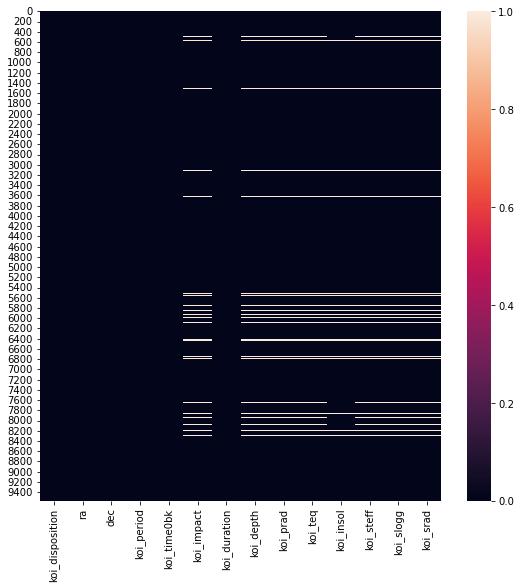

In [5]:
sns.heatmap(df.isna())

 **Lots of NA values.**

In [796]:
# df.drop(['koi_teq_err1','koi_teq_err2'], axis=1, inplace=True) # COLUMNS OF ALL NAS

In [797]:
print(df[df.isnull()['koi_impact']]['koi_disposition'].value_counts());
print()
print(f'The proportion of False Positives: {299/(299+63)}')

FALSE POSITIVE    299
CANDIDATE          63
CONFIRMED           1
Name: koi_disposition, dtype: int64

The proportion of False Positives: 0.8259668508287292


In [798]:
print(df[df.isnull()['koi_srad']]['koi_disposition'].value_counts());
print()
print(f'The proportion of False Positives: {np.around(299/(299+63),3)}')

FALSE POSITIVE    299
CANDIDATE          63
CONFIRMED           1
Name: koi_disposition, dtype: int64

The proportion of False Positives: 0.826


In [799]:
df.koi_disposition.value_counts()
proportion = 5023/(2293 + 5023)
print(f'The propotion of False Positives on training dataset {np.around(proportion,3)}')

The propotion of False Positives on training dataset 0.687


This shows that the proportion of False positives among the NA values is around 14% higher. 

In [800]:
df.dropna(inplace=True) # solution is to just drop them.

In [802]:
# Bit of an uneven distribution. 
df.koi_disposition.value_counts()

FALSE POSITIVE    4724
CONFIRMED         2292
CANDIDATE         2185
Name: koi_disposition, dtype: int64

### Checking the distribution differences 

<AxesSubplot:>

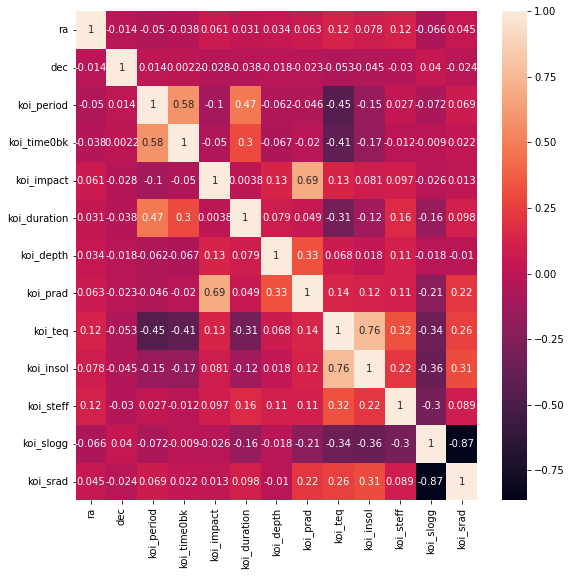

In [804]:
sns.heatmap(df.corr(), annot=True)  

High correlation values on (koi_Slogg,koi_Srad), (koi_prad, koi_impact).

In [805]:
df_test = df[df.koi_disposition == 'CANDIDATE']
df_train = df[df.koi_disposition != 'CANDIDATE']

In [806]:
print(f'the maximum of koi impact from test set: {df_test.koi_impact.max()}')
print(f'the average of koi impact from test set: {np.around(df_test.koi_impact.mean(),3)}')
print()
print(f'the maximum of koi impact from training set: {df_train.koi_impact.max()}')
print(f'the average of koi impact from training set: {np.around(df_train.koi_impact.mean(),3)}')

the maximum of koi impact from test set: 8.7053
the average of koi impact from test set: 0.473

the maximum of koi impact from training set: 10.337
the average of koi impact from training set: 0.608


In [374]:
# sns.kdeplot(x = 'koi_impact', hue='koi_disposition', data=df)

### Compare significant features in logistic regression with those in permutation test. 

In [352]:
from pprint import PrettyPrinter
from scipy.stats import kstest 
pp = PrettyPrinter(indent=4)

In [353]:
ks_tests = {}
for col in df.columns:
    dist_test = kstest(df_test[col], df_train[col])[1]
    ks_tests[col] = np.around(dist_test,4)
pp.pprint(ks_tests)

{   'dec': 0.2771,
    'koi_depth': 0.0,
    'koi_disposition': 0.896,
    'koi_duration': 0.0,
    'koi_impact': 0.0,
    'koi_period': 0.0,
    'koi_prad': 0.0,
    'koi_slogg': 0.8041,
    'koi_srad': 0.9338,
    'koi_steff': 0.0042,
    'koi_teq': 0.0,
    'koi_time0bk': 0.0,
    'ra': 0.0098}


In [911]:
pd.Series(ks_tests)[1:].plot.bar()

NameError: name 'ks_tests' is not defined

# PCA

In [912]:
from sklearn.decomposition import PCA

In [914]:
df = pd.read_csv('/Users/gabrielnicholson/Desktop/KOI.csv')

# This only keeps non-error columns
predictor_list = []
for i in df.columns:
    if '2' in i or '1' in i:
        pass
    else:
        predictor_list.append(i)

predictor_list = predictor_list[1:] # removing kepid
df = df[predictor_list] # This is when removing the error columns
df.drop(df.iloc[:,3:7].columns,axis=1,inplace=True) # Removes flag variables

df.dropna(inplace=True) # solution is to just drop them.
df.drop(['ra', 'dec'], axis=1, inplace=True)
df.drop('koi_insol', axis=1, inplace=True)

In [809]:
df_test = df[df.koi_disposition == 'CANDIDATE']
df_train = df[df.koi_disposition != 'CANDIDATE']

X_train = df_train.drop('koi_disposition',axis=1).rank(pct=True)
X_test = df_test.drop('koi_disposition',axis=1).rank(pct=True)

all_X = df.drop('koi_disposition',axis=1).rank(pct=True)

In [810]:
all_X.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
df.reset_index(inplace=True, drop=True)
df = pd.concat((df.koi_disposition,all_X),axis=1) # Put koi_disposition back after not giving it a rank.

In [811]:
pca = PCA(n_components=5)
pca_transformed = pca.fit_transform(all_X)

In [812]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=500, n_init=30, random_state=42)
df['cluster'] = kmeans.fit_predict(pca_transformed)

In [813]:
df_test = df[df.koi_disposition == 'CANDIDATE']
X_test = df_test.drop(['koi_disposition', 'cluster'],axis=1).rank(pct=True)
X_test.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)
test_df = pd.concat((X_test, df_test[['koi_disposition', 'cluster']]),axis=1)

In [921]:
%matplotlib inline

<AxesSubplot:>

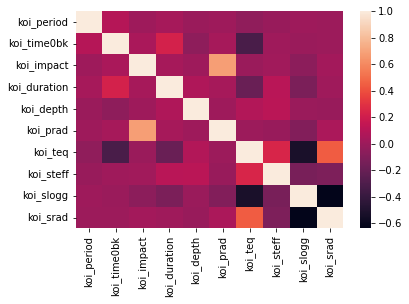

In [923]:
plt.plot(df.koi_steff)
sns.heatmap(df.corr())

<AxesSubplot:xlabel='koi_period', ylabel='koi_impact'>

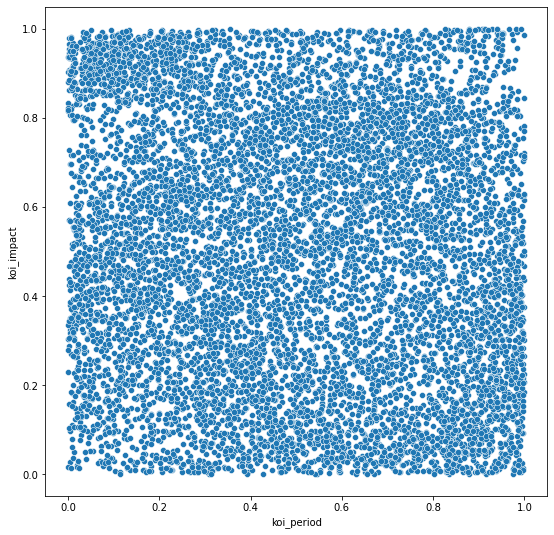

In [908]:
sns.scatterplot(data=df, x='koi_period', y='koi_impact')

### Weighting

In [484]:
num_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts()
num_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts()

train_df = df[df.koi_disposition != 'CANDIDATE']
test_df = df[df.koi_disposition == 'CANDIDATE']

train_cluster_len = [num_train_clusters[i] for i in range(len(num_train_clusters))] # The indexes are in order of cluster.
test_cluster_len = [num_test_clusters[i] for i in range(len(num_test_clusters))] # The indexes are in order of cluster.

total_train_clus = np.sum(train_cluster_len)
total_test_clus = np.sum(test_cluster_len)

In [487]:
denominator_to_N = 0 

for c_num in train_df.cluster:
    q_test =  test_cluster_len[c_num] / total_test_clus
    q_train = train_cluster_len[c_num] / total_train_clus
    denominator_to_N += (q_test/q_train)

denominator_to_N

weights = []

for c_num in train_df.cluster:
    q_test =  test_cluster_len[c_num] / total_test_clus
    q_train = train_cluster_len[c_num] / total_train_clus
    weight_i = (q_test/q_train)/((q_test/q_train)+denominator_to_N)
    weights.append(weight_i)

In [687]:
df_train = df[df.koi_disposition != 'CANDIDATE']
df_train.reset_index(inplace=True, drop=True)

In [499]:
from sklearn.linear_model import LogisticRegression
X = df_train.drop('koi_disposition', axis=1)
train_y = df_train.koi_disposition
model = LogisticRegression(max_iter=10000, C=3)
model.fit(X, train_y)

LogisticRegression(C=3, max_iter=10000)

In [496]:
model.classes_

array(['CONFIRMED', 'FALSE POSITIVE'], dtype=object)

In [500]:
scores_confirmed = 1/model.predict_proba(X)[:,0]
scores_fp = 1/model.predict_proba(X)[:,1]

confirmed_df = pd.DataFrame({'Scores of Confirmed':scores_confirmed, 'Weights':weights})
false_positive_df =  pd.DataFrame({'false positive score':scores_fp, 'Weights':weights})

confirmed_df.sort_values(by='Scores of Confirmed',inplace=True)
false_positive_df.sort_values(by='false positive score',inplace=True)

confirmed_df['weight_cdf'] = np.cumsum(confirmed_df['Weights'])
false_positive_df['weight_cdf'] = np.cumsum(false_positive_df['Weights'])

In [503]:
df_test = df[df.koi_disposition == 'CANDIDATE']
X_test = df_test.drop(['koi_disposition', 'cluster'],axis=1).rank(pct=True)
X_test.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)
test_df = pd.concat((X_test, df_test[['koi_disposition', 'cluster']]),axis=1)

In [504]:
test_df.head() # Should have clusters and ranked x values with string KOI dosposition values.

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_steff,koi_slogg,koi_srad,koi_disposition,cluster
0,0.246224,0.776201,0.786499,0.275057,0.972540,0.914874,0.757666,0.492220,0.352632,0.615561,CANDIDATE,2
1,0.707551,0.783524,0.843936,0.490618,0.962014,0.879176,0.234325,0.320595,0.661327,0.175286,CANDIDATE,3
2,0.353318,0.481465,0.965904,0.005950,0.731350,0.936384,0.468879,0.146911,0.874828,0.154233,CANDIDATE,0
3,0.168421,0.168421,0.648741,0.444394,0.008238,0.012815,0.837300,0.544851,0.329977,0.622883,CANDIDATE,4
4,0.078261,0.756064,0.984668,0.247368,0.907094,0.966590,0.907323,0.504577,0.421281,0.480549,CANDIDATE,2


In [505]:
extra_row = test_df.iloc[0]
conformal_df = df_train.append(extra_row) # appends the test row to the bottom  of training data

In [506]:
conformal_df

,koi_disposition,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_steff,koi_slogg,koi_srad,cluster
0,CONFIRMED,0.504402,0.752853,0.207640,0.348169,0.596674,0.475166,0.441908,0.311216,0.564178,0.397185,3
1,CONFIRMED,0.794588,0.717857,0.532714,0.593414,0.673405,0.569449,0.179491,0.311216,0.564178,0.397185,3
2,FALSE POSITIVE,0.656450,0.808608,0.829258,0.124878,0.849364,0.748071,0.325345,0.571297,0.752310,0.311923,3
3,FALSE POSITIVE,0.179220,0.748723,0.971416,0.241822,0.838604,0.834420,0.754266,0.537659,0.804749,0.191229,2
4,CONFIRMED,0.240409,0.769373,0.614988,0.102380,0.591784,0.559722,0.758124,0.685849,0.498044,0.566732,2
...,...,...,...,...,...,...,...,...,...,...,...,...
7012,FALSE POSITIVE,0.485165,0.133138,0.664547,0.627323,0.130203,0.149658,0.532062,0.420172,0.307521,0.611510,4
7013,FALSE POSITIVE,0.010651,0.052060,0.950929,0.397674,0.757092,0.817629,0.906532,0.420172,0.716661,0.365286,2
7014,FALSE POSITIVE,0.046517,0.173351,0.208401,0.013694,0.155309,0.136507,0.923487,0.786328,0.521193,0.561298,4
7015,FALSE POSITIVE,0.359744,0.463374,0.199163,0.370123,0.107869,0.131453,0.709814,0.910281,0.401641,0.685904,4


Now will train logistic classifier on extra sample and then impute a value for y. Then we will recalculate the table but while keeping track of the score value. 
Then we will see if the score value is within the 1-alpha bound.

In [508]:
X = conformal_df.drop(['koi_disposition', 'cluster'], axis=1)
y = conformal_df['koi_disposition']

In [509]:
y.iloc[-1] = 'CONFIRMED' # Put in the guessed value for y. 

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [511]:
y.tail(3)

7014    FALSE POSITIVE
7015    FALSE POSITIVE
0            CONFIRMED
Name: koi_disposition, dtype: object

In [512]:
model = LogisticRegression(max_iter=10000, C=3)
model.fit(X, y)

LogisticRegression(C=3, max_iter=10000)

In [513]:
train_cluster_len = [num_train_clusters[i] for i in range(len(num_train_clusters))] # The indexes are in order of cluster.
test_cluster_len = [num_test_clusters[i] for i in range(len(num_test_clusters))] # The indexes are in order of cluster.

total_train_clus = np.sum(train_cluster_len)
total_test_clus = np.sum(test_cluster_len)

In [515]:
conformal_df

,koi_disposition,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_steff,koi_slogg,koi_srad,cluster
0,CONFIRMED,0.504402,0.752853,0.207640,0.348169,0.596674,0.475166,0.441908,0.311216,0.564178,0.397185,3
1,CONFIRMED,0.794588,0.717857,0.532714,0.593414,0.673405,0.569449,0.179491,0.311216,0.564178,0.397185,3
2,FALSE POSITIVE,0.656450,0.808608,0.829258,0.124878,0.849364,0.748071,0.325345,0.571297,0.752310,0.311923,3
3,FALSE POSITIVE,0.179220,0.748723,0.971416,0.241822,0.838604,0.834420,0.754266,0.537659,0.804749,0.191229,2
4,CONFIRMED,0.240409,0.769373,0.614988,0.102380,0.591784,0.559722,0.758124,0.685849,0.498044,0.566732,2
...,...,...,...,...,...,...,...,...,...,...,...,...
7012,FALSE POSITIVE,0.485165,0.133138,0.664547,0.627323,0.130203,0.149658,0.532062,0.420172,0.307521,0.611510,4
7013,FALSE POSITIVE,0.010651,0.052060,0.950929,0.397674,0.757092,0.817629,0.906532,0.420172,0.716661,0.365286,2
7014,FALSE POSITIVE,0.046517,0.173351,0.208401,0.013694,0.155309,0.136507,0.923487,0.786328,0.521193,0.561298,4
7015,FALSE POSITIVE,0.359744,0.463374,0.199163,0.370123,0.107869,0.131453,0.709814,0.910281,0.401641,0.685904,4


In [521]:
denominator = 0 

for c_num in conformal_df.cluster:
    q_test =  test_cluster_len[c_num] / total_test_clus
    q_train = train_cluster_len[c_num] / total_train_clus
    denominator += (q_test/q_train)
    
print(denominator)

weights = []
for c_num in conformal_df.cluster:
    q_test =  test_cluster_len[c_num] / total_test_clus
    q_train = train_cluster_len[c_num] / total_train_clus
    weight_i = (q_test / q_train) / ((q_test/q_train) + denominator)
    weights.append(weight_i)

In [522]:
scores_confirmed = 1/model.predict_proba(X)[:,0]
scores_fp = 1/model.predict_proba(X)[:,1]

TEST_SCORE = scores_confirmed[-1]

confirmed_df = pd.DataFrame({'Scores of Confirmed':scores_confirmed, 'Weights':weights})
false_positive_df =  pd.DataFrame({'false positive score':scores_fp, 'Weights':weights})

confirmed_df.sort_values(by='Scores of Confirmed',inplace=True)
false_positive_df.sort_values(by='false positive score',inplace=True)

confirmed_df['weight_cdf'] = np.cumsum(confirmed_df['Weights'])
false_positive_df['weight_cdf'] = np.cumsum(false_positive_df['Weights'])

# INFERENCE Full Conformal

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'

In [8]:
from sklearn.decomposition import PCA
import scipy.stats as stats
df = pd.read_csv('/Users/gabrielnicholson/Desktop/KOI.csv')

# This only keeps non-error columns
predictor_list = []
for i in df.columns:
    if '2' in i or '1' in i:
        pass
    else:
        predictor_list.append(i)

predictor_list = predictor_list[1:] # removing kepid
df = df[predictor_list] # This is when removing the error columns
df.drop(df.iloc[:,3:7].columns,axis=1,inplace=True) # Removes flag variables

df.dropna(inplace=True) # solution is to just drop them.
df.drop(['ra', 'dec'], axis=1, inplace=True)
df.drop('koi_insol', axis=1, inplace=True)
df_test = df[df.koi_disposition == 'CANDIDATE']
df_train = df[df.koi_disposition != 'CANDIDATE']

X_train = df_train.drop('koi_disposition',axis=1).rank(pct=True)
X_test = df_test.drop('koi_disposition',axis=1).rank(pct=True)

all_X = df.drop('koi_disposition',axis=1).rank(pct=True)
all_X.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
df.reset_index(inplace=True, drop=True)
df = pd.concat((df.koi_disposition,all_X),axis=1) # Put koi_disposition back after not giving it a rank.


In [885]:
pca = PCA(n_components=5)
pca_transformed = pca.fit_transform(all_X)

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=500, n_init=30, random_state=42)
df['cluster'] = kmeans.fit_predict(pca_transformed)

<AxesSubplot:>

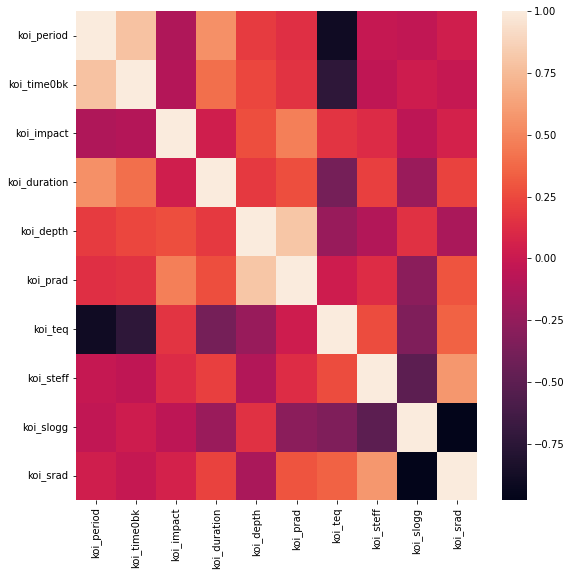

In [10]:
sns.heatmap(df.corr())

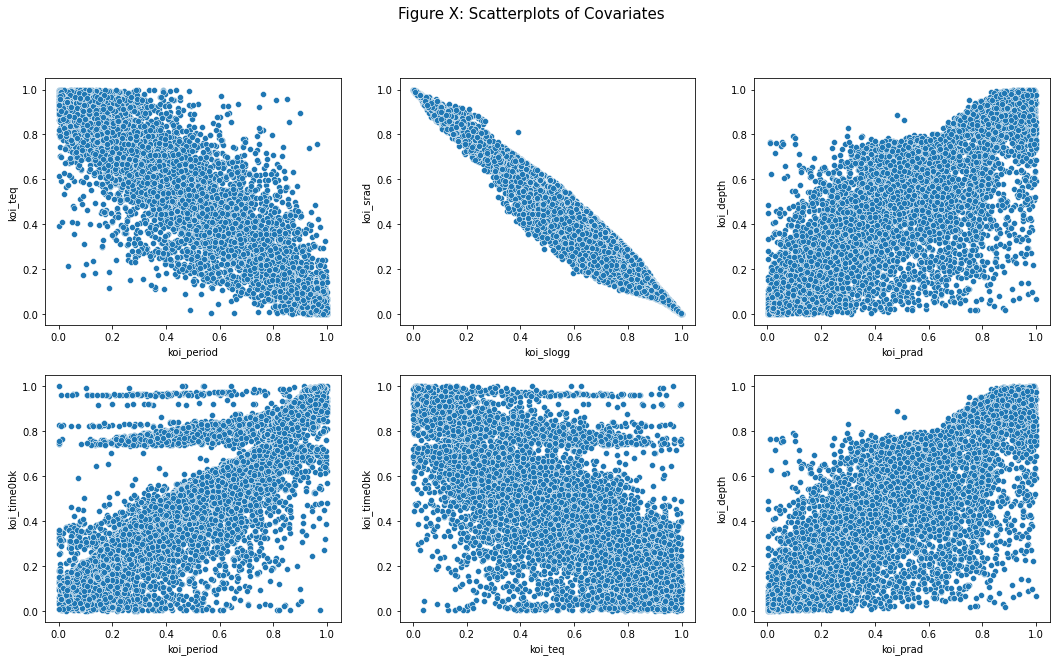

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.scatterplot(ax=axes[0, 0], data=df, x = 'koi_period', y = 'koi_teq')
# axes[0, 0].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

sns.scatterplot(ax=axes[0, 1], data=df, x = 'koi_slogg', y = 'koi_srad')
# axes[0, 1].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

sns.scatterplot(ax=axes[0, 2], data=df, x = 'koi_prad', y = 'koi_depth')
# axes[0, 2].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

sns.scatterplot(ax=axes[1, 0], data=df, x = 'koi_period', y = 'koi_time0bk')
# axes[0, 2].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')
# axes[1, 0].set_xlabel('Residual Correlations')

sns.scatterplot(ax=axes[1, 1], data=df, x = 'koi_teq', y = 'koi_time0bk')
# axes[0, 2].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')
# axes[1, 1].set_xlabel('Residual Correlations')

sns.scatterplot(ax=axes[1, 2], data=df, x = 'koi_prad', y = 'koi_depth')

# axes[0, 2].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')
# axes[1, 2].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
# axes[1, 2].set_xlabel('Residual Correlations')


plt.suptitle('Figure X: Scatterplots of Covariates', fontsize=15)

# axes[0, 2].legend(loc="upper right", bbox_to_anchor=(
#     1.7, 1), prop={'size': 12})

plt.savefig('fig5.png')


<AxesSubplot:xlabel='koi_period', ylabel='koi_teq'>

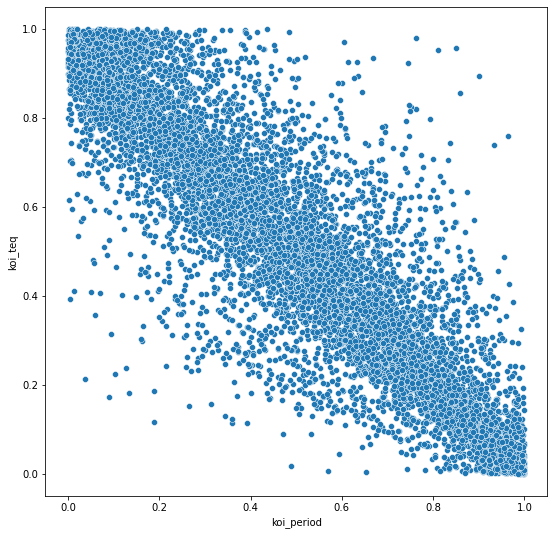

In [11]:
fig, axs = plt.subplot()

fig, axs = plt.subplots(ncols=2, figsize=(14,8))

sns.scatterplot(data=df,x = 'koi_period', y = 'koi_teq')

In [886]:
df_test = df[df.koi_disposition == 'CANDIDATE']
X_test = df_test.drop(['koi_disposition', 'cluster'],axis=1).rank(pct=True)
X_test.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)
test_df = pd.concat((X_test, df_test[['koi_disposition', 'cluster']]),axis=1)
df_train = df[df.koi_disposition != 'CANDIDATE']
df_train.reset_index(inplace=True, drop=True)

num_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts()
num_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts()

train_cluster_len = [num_train_clusters[i] for i in range(len(num_train_clusters))] # The indexes are in order of cluster.
test_cluster_len = [num_test_clusters[i] for i in range(len(num_test_clusters))] # The indexes are in order of cluster.

total_train_clus = np.sum(train_cluster_len)
total_test_clus = np.sum(test_cluster_len)

In [841]:
plt_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts(normalize=True)
plt_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts(normalize=True)

In [897]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [900]:
chi_square_value, p_value = calculate_bartlett_sphericity(df.drop(['koi_disposition', 'cluster'],axis=1))
print(f'chi_square_value: {chi_square_value}')
print(f'p_value: {p_value}')

chi_square_value: 97803.2245377728
p_value: 0.0


In [894]:
stats.bartlett(df['koi_period'], df['koi_impact'], df['koi_time0bk'], df['koi_duration'], df['koi_depth'], df['koi_prad'], df['koi_teq'])

BartlettResult(statistic=7.592874961401517e-08, pvalue=1.0)

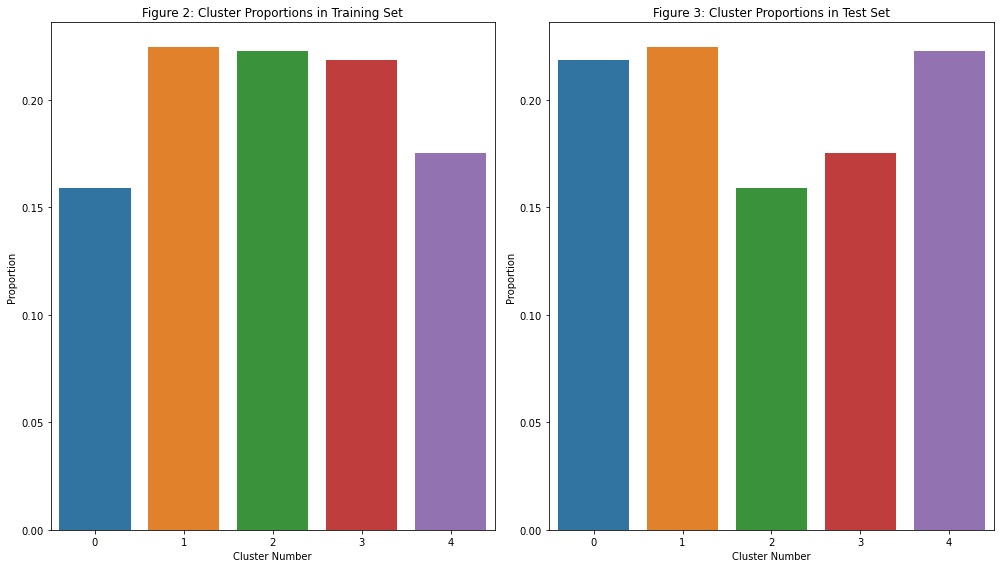

In [871]:
fig, axs = plt.subplots(ncols=2, figsize=(14,8))
fig = sns.barplot(x = plt_train_clusters.index, y = plt_train_clusters, ax=axs[0])
fig.set_title('Figure 2: Cluster Proportions in Training Set')
fig.set_ylabel('Proportion')
fig.set_xlabel('Cluster Number')

fig = sns.barplot(x = plt_test_clusters.index, y = plt_train_clusters, ax=axs[1])
fig.set_title('Figure 3: Cluster Proportions in Test Set')
fig.set_ylabel('Proportion')
fig.set_xlabel('Cluster Number')
plt.tight_layout()
plt.savefig('figure 2 & 3')

In [840]:
num_test_clusters/num_test_clusters.sum()

1    0.281465
4    0.232494
0    0.228833
3    0.195881
2    0.061327
Name: cluster, dtype: float64

In [724]:
def full_conformal(test_row, cp_df_train, alpha):
    cp_conformal_df = cp_df_train.append(test_row) # appends the test row to the bottom  of training data
    X = cp_conformal_df.drop(['koi_disposition', 'cluster'], axis=1)
    y = cp_conformal_df['koi_disposition']

    # Calculates the denominator.
    denominator = 0 
    for c_num in cp_conformal_df.cluster:
        q_test =  test_cluster_len[c_num] / total_test_clus
        q_train = train_cluster_len[c_num] / total_train_clus
        denominator += (q_test/q_train)
    
    # Calculates the weights for each cluster.
    weights = []
    for c_num in cp_conformal_df.cluster:
        q_test =  test_cluster_len[c_num] / total_test_clus
        q_train = train_cluster_len[c_num] / total_train_clus
        weight_i = (q_test / q_train) / (denominator)
        weights.append(weight_i)

    y.iloc[-1] = 'CONFIRMED'        # Put in the guessed value for y. 
    model_confirmed = LogisticRegression(max_iter=10000, C=1)
    model_confirmed.fit(X, y)

    y.iloc[-1] = 'FALSE POSITIVE'   # Put in the guessed value for y. 
    model_false_positive = LogisticRegression(max_iter=10000, C=1)
    model_false_positive.fit(X, y)

    scores_confirmed = 1/model_confirmed.predict_proba(X)[:,0]
    scores_fp = 1/model_false_positive.predict_proba(X)[:,1]

    # Keeps track of score on test sample.
    TEST_SCORE_confirmed = scores_confirmed[-1]
    TEST_SCORE_FP = scores_fp[-1]

    confirmed_df = pd.DataFrame({'Scores of Confirmed':scores_confirmed, 'Weights':weights})
    false_positive_df =  pd.DataFrame({'false positive score':scores_fp, 'Weights':weights})

    confirmed_df.sort_values(by='Scores of Confirmed',inplace=True)
    false_positive_df.sort_values(by='false positive score',inplace=True)

    confirmed_df['weight_cdf'] = np.cumsum(confirmed_df['Weights'])
    false_positive_df['weight_cdf'] = np.cumsum(false_positive_df['Weights'])

    # Checking if the score is within the 1-alpha weight quantile.
    prediction_set = []
    score_Q_confirmed = confirmed_df[confirmed_df['weight_cdf'] <= (1-alpha)]['Scores of Confirmed'].iloc[-1]
    score_Q_false_positive = false_positive_df[false_positive_df['weight_cdf'] <= (1-alpha)]['false positive score'].iloc[-1]

    if TEST_SCORE_confirmed < score_Q_confirmed:
        prediction_set.append('CONFIRMED')

    if TEST_SCORE_FP < score_Q_false_positive:
        prediction_set.append('FALSE POSITIVE')
    
    return prediction_set, confirmed_df

In [737]:
cp_df_train = df_train.copy()

In [739]:
predictions = []
for row in tqdm(range(len(df_test))):
    prediction_set, confirmed_df = full_conformal(test_row=df_test.iloc[row], cp_df_train=cp_df_train, alpha=0.1)
    predictions.append(prediction_set)

100%|██████████| 2185/2185 [03:08<00:00, 11.60it/s]


In [740]:
confirmed_df

,Scores of Confirmed,Weights,weight_cdf
4439,1.026879,0.000147,0.000147
563,1.030000,0.000147,0.000294
3021,1.030135,0.000147,0.000440
2331,1.030681,0.000147,0.000587
5932,1.044452,0.000147,0.000734
...,...,...,...
5784,181.411834,0.000047,0.999666
5240,188.204553,0.000047,0.999712
5941,193.937325,0.000047,0.999759
4398,222.299002,0.000194,0.999953


In [723]:
c = 0
for i in predictions:
    c+= len(i)
c

3940

### Verifying K-Means and PCA

In [271]:
from sklearn.cluster import KMeans

In [609]:
all = all_X.copy()

In [612]:
# Or fit on all the data.
pca = PCA(n_components=5)
all = pca.fit_transform(all)
pca.explained_variance_ratio_.sum() # 5 components can explain 91% variance. 

0.910699232506103

In [624]:
pca_train = all[np.where(df.koi_disposition != 'CANDIDATE')]
pca_test = all[np.where(df.koi_disposition == 'CANDIDATE')]

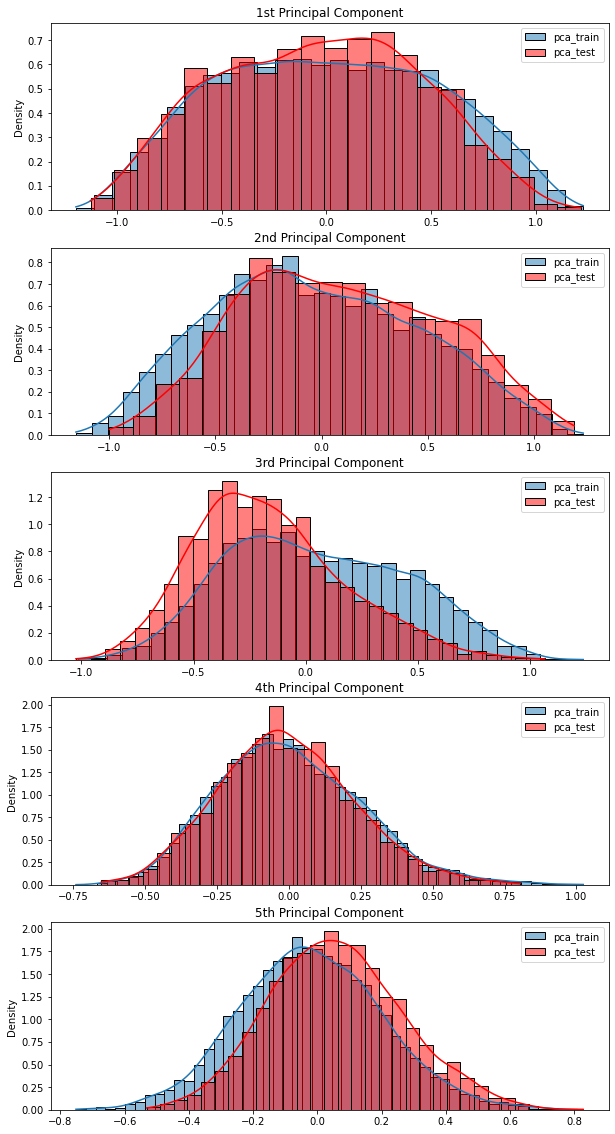

In [670]:
fig, axs = plt.subplots(nrows=5, figsize=(10,20))


sns.histplot(pca_train[:,0], label='pca_train', ax=axs[0], kde=True, stat='density')
sns.histplot(pca_test[:,0], color='r', label='pca_test', ax=axs[0], kde=True,stat='density')
axs[0].set_title('1st Principal Component')
sns.histplot(pca_train[:,1], label='pca_train', ax=axs[1], kde=True,stat='density')
sns.histplot(pca_test[:,1], color='r', label='pca_test', kde=True,ax=axs[1], stat='density')
axs[1].set_title('2nd Principal Component')
sns.histplot(pca_train[:,2], label='pca_train', ax=axs[2], kde=True,stat='density')
sns.histplot(pca_test[:,2], color='r', label='pca_test', kde=True,ax=axs[2], stat='density')
axs[2].set_title('3rd Principal Component')
sns.histplot(pca_train[:,3], label='pca_train', ax=axs[3], kde=True,stat='density')
sns.histplot(pca_test[:,3], color='r', label='pca_test', ax=axs[3], kde=True,stat='density')
axs[3].set_title('4th Principal Component')
sns.histplot(pca_train[:,4], label='pca_train', ax=axs[4], kde=True, stat='density')
sns.histplot(pca_test[:,4], color='r', label='pca_test', ax=axs[4], kde=True, stat='density')
axs[4].set_title('5th Principal Component')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

plt.suptitle('Figure 3: ')
plt.savefig('fig')


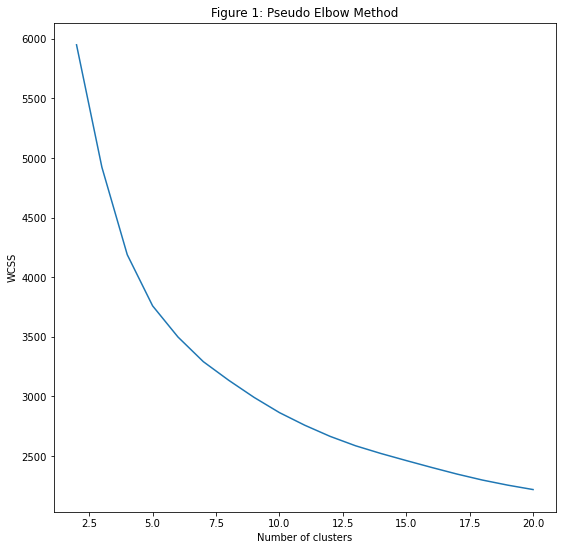

In [790]:
max_clusters = 20

wcss = []
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=25, random_state=42)
    kmeans.fit(all_X)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, max_clusters + 1), wcss)
plt.title('Figure 1: Pseudo Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('figure 1')

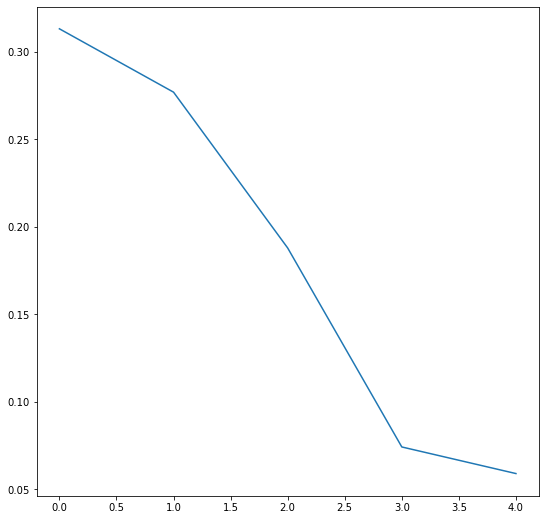

In [274]:
plt.plot(pca.explained_variance_ratio_)

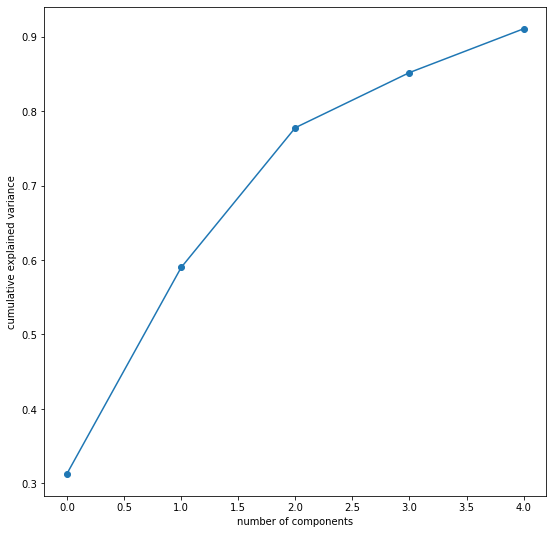

In [673]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Logit Regression

In [752]:
from statsmodels.discrete.discrete_model import Logit

In [762]:
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.tools import add_constant

In [743]:
df_train

,koi_disposition,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_steff,koi_slogg,koi_srad,cluster
0,CONFIRMED,0.504402,0.752853,0.207640,0.348169,0.596674,0.475166,0.441908,0.311216,0.564178,0.397185,1
1,CONFIRMED,0.794588,0.717857,0.532714,0.593414,0.673405,0.569449,0.179491,0.311216,0.564178,0.397185,1
2,FALSE POSITIVE,0.656450,0.808608,0.829258,0.124878,0.849364,0.748071,0.325345,0.571297,0.752310,0.311923,1
3,FALSE POSITIVE,0.179220,0.748723,0.971416,0.241822,0.838604,0.834420,0.754266,0.537659,0.804749,0.191229,3
4,CONFIRMED,0.240409,0.769373,0.614988,0.102380,0.591784,0.559722,0.758124,0.685849,0.498044,0.566732,3
...,...,...,...,...,...,...,...,...,...,...,...,...
7011,FALSE POSITIVE,0.685904,0.667754,0.878709,0.901750,0.840235,0.779589,0.265732,0.248886,0.589610,0.293881,1
7012,FALSE POSITIVE,0.485165,0.133138,0.664547,0.627323,0.130203,0.149658,0.532062,0.420172,0.307521,0.611510,2
7013,FALSE POSITIVE,0.010651,0.052060,0.950929,0.397674,0.757092,0.817629,0.906532,0.420172,0.716661,0.365286,3
7014,FALSE POSITIVE,0.046517,0.173351,0.208401,0.013694,0.155309,0.136507,0.923487,0.786328,0.521193,0.561298,2


In [778]:
X = df_train.drop(['koi_disposition', 'cluster'], axis=1)

In [771]:
y = pd.get_dummies(df_train.koi_disposition,drop_first=True).to_numpy()

In [779]:
X = add_constant(X)

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [780]:
model = Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [883]:
results_summary = model.summary()
print(results_summary)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7016
Model:                          Logit   Df Residuals:                     7005
Method:                           MLE   Df Model:                           10
Date:                Tue, 15 Mar 2022   Pseudo R-squ.:                     inf
Time:                        20:19:10   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.1309      0.654     -3.257      0.001      -3.413      -0.849
koi_period       2.0401      0.500      4.081      0.000       1.060       3.020
koi_time0bk     -1.2231      0.163     -7.51

In [305]:
prediction = model.predict(X_test)

In [306]:
model.score(X_test, y_test)

0.8105375199574242

In [307]:
confusion_matrix(y_test, prediction)

array([[549, 144],
       [212, 974]])

In [308]:
print(classification_report(y_test, prediction))

                precision    recall  f1-score   support

     CONFIRMED       0.72      0.79      0.76       693
FALSE POSITIVE       0.87      0.82      0.85      1186

      accuracy                           0.81      1879
     macro avg       0.80      0.81      0.80      1879
  weighted avg       0.82      0.81      0.81      1879



<AxesSubplot:>

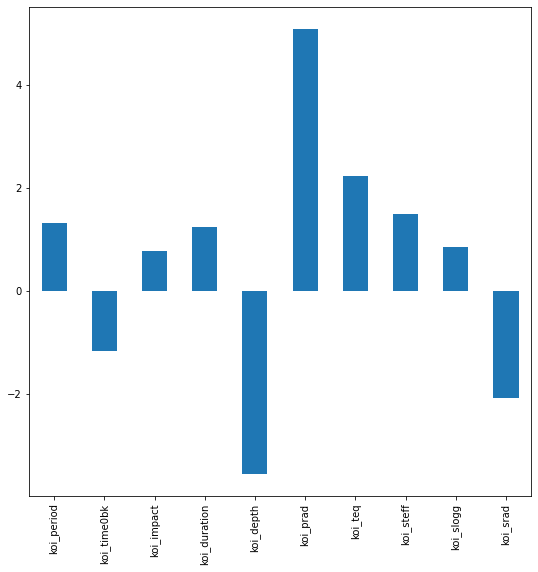

In [749]:
feature_list = dict(zip(model.feature_names_in_,np.around(model.coef_[0],3)))
pd.Series(feature_list).plot.bar()

# Permutation test for distribution check

#### Permutation tests

In [313]:
from scipy.stats import ttest_ind
from scipy.stats import median_test

In [314]:
t_test_p_vals = {}
for col in df_train.columns[1:]:
    p_val = ttest_ind(df_test[col], df_train[col],permutations=20000, equal_var=False)[1]
    t_test_p_vals[col] = p_val

In [315]:
pp.pprint(t_test_p_vals) # Equal variance = False

{   'dec': 0.35305,
    'koi_depth': 0.0,
    'koi_duration': 0.0,
    'koi_impact': 0.0,
    'koi_insol': 0.0,
    'koi_period': 0.0063,
    'koi_prad': 0.0,
    'koi_slogg': 0.5487,
    'koi_srad': 0.3019,
    'koi_steff': 0.00185,
    'koi_teq': 0.0,
    'koi_time0bk': 0.20385,
    'ra': 0.0105}


In [162]:
pp.pprint(t_test_p_vals) # Equal variance assumption = True

{   'dec': 0.0778,
    'koi_depth': 0.0,
    'koi_duration': 0.0,
    'koi_impact': 0.00265,
    'koi_insol': 0.47005,
    'koi_period': 0.0,
    'koi_prad': 0.0897,
    'koi_slogg': 0.00855,
    'koi_srad': 0.15415,
    'koi_steff': 0.0,
    'koi_teq': 0.0,
    'koi_time0bk': 0.0002,
    'ra': 0.00215}


In [180]:
def permut_p_value(column_name, num_perm=15000, variance=False):
    """ 
    """
    permutation_statistics = []
    if variance:
        original_statistic = np.var(df_test[column_name])
        for i in range(num_perm):
            permutation = np.random.permutation(df[column_name])[:2185]
            variance_of_permutation = np.var(permutation)
            permutation_statistics.append(variance_of_permutation)
    else:
        stat, p, med, tbl = median_test(df_test[column_name], df_train[column_name])
        original_statistic = np.abs(stat)
        for i in range(num_perm):
            permutation_set = np.random.permutation(df[column_name])
            test_set = permutation_set[:2185]
            train_set = permutation_set[2185:]
            stat,perm_stat,_,_ = median_test(test_set, train_set)
            permutation_statistics.append(stat)
    permutation_statistics = np.array(permutation_statistics)

    p_val = 1 + sum(np.abs(permutation_statistics) >= original_statistic)/(num_perm - 1) # Is there a one minus in denominator?
    return p_val


In [181]:
median_p_values = []
for column_name in tqdm(df.columns[1:]):
    median_p_values.append(permut_p_value(column_name, variance=False))

100%|██████████| 13/13 [01:38<00:00,  7.59s/it]


In [182]:
median_p_values

[1.0962064137609173,
 1.065071004733649,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.000600040002667,
 1.0372691512767518,
 1.4824988332555504]

In [391]:
def permut_p_value(column_name, num_perm=15000):
    """ 
    Permute using the KS test statistic.
    """
    permutation_statistics = []
    original_statistic = kstest(df_test[column_name], df_train[column_name])[1]
    for i in range(num_perm):
        shuffled_df = np.random.permutation(df[column_name])
        test_permutation = shuffled_df[:2185]
        train_permutation = shuffled_df[2185:]
        ks_statistic = kstest(test_permutation, train_permutation)[1]
        permutation_statistics.append(ks_statistic)
    permutation_statistics = np.array(permutation_statistics)

    p_val = (1 + sum(permutation_statistics <= original_statistic))/(num_perm)
    return np.around(p_val,4)


In [392]:
p_values_permut = {}
for col in tqdm(df.columns[1:]):
    p_val = permut_p_value(col)
    p_values_permut[col] = p_val

100%|██████████| 17/17 [1:04:52<00:00, 228.99s/it]


In [395]:
pd.Series(p_values_permut).to_csv('p_values.csv')

In [396]:
pd.read_csv('p_values.csv')

,Unnamed: 0,0
0,ra,0.0022
1,dec,0.0725
2,koi_fpflag_nt,0.0001
3,koi_fpflag_ss,0.0001
4,koi_fpflag_co,0.0001
5,koi_fpflag_ec,0.0001
6,koi_period,0.0001
7,koi_time0bk,0.0001
8,koi_impact,0.0001
9,koi_duration,0.0001


In [248]:
dict(zip(df.columns[1:],mean_p_values))

{'ra': 0.0004,
 'dec': 0.9651,
 'koi_fpflag_nt': 0.0,
 'koi_fpflag_ss': 0.0,
 'koi_fpflag_co': 0.0,
 'koi_fpflag_ec': 0.0,
 'koi_period': 1.0,
 'koi_time0bk': 0.99995,
 'koi_impact': 0.0,
 'koi_duration': 0.0,
 'koi_depth': 0.0,
 'koi_prad': 0.0,
 'koi_teq': 0.0,
 'koi_insol': 0.2526,
 'koi_steff': 0.0,
 'koi_slogg': 0.9956,
 'koi_srad': 0.0721}

In [249]:
dict(zip(df.columns[1:],variance_p_values))

{'ra': 0.9338,
 'dec': 0.54635,
 'koi_fpflag_nt': 0.0,
 'koi_fpflag_ss': 0.0,
 'koi_fpflag_co': 0.0,
 'koi_fpflag_ec': 0.0,
 'koi_period': 0.9996,
 'koi_time0bk': 0.99045,
 'koi_impact': 0.07015,
 'koi_duration': 0.0,
 'koi_depth': 0.0,
 'koi_prad': 0.0565,
 'koi_teq': 0.0,
 'koi_insol': 0.5973,
 'koi_steff': 0.0,
 'koi_slogg': 0.0113,
 'koi_srad': 0.46375}

# Prediction

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
example_set = df[df.koi_disposition != 'CANDIDATE']
y = example_set['koi_disposition']
X = example_set.drop('koi_disposition', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 1.14521193,  0.90535619,  0.33989873, ..., -2.99905102,
         1.29100101, -0.61688487],
       [ 0.67375057,  0.84904743, -0.44250405, ...,  0.48568048,
         0.43433357, -0.2571353 ],
       [ 0.79197369, -0.12479744, -0.41779394, ..., -1.00798007,
        -4.16628788,  5.90221337],
       ...,
       [-0.08063847, -1.46674609, -0.38869962, ...,  0.77154853,
         0.28434465, -0.17137682],
       [-0.6219859 ,  0.62872621, -0.07923864, ...,  0.3227357 ,
        -0.92710425,  0.27776507],
       [ 0.52886545,  0.37097471,  0.04412746, ..., -1.81269862,
         0.94198835, -0.51513752]])